<a href="https://colab.research.google.com/github/v4chelsea/Style_Transfer/blob/main/StyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [415]:
# Google Drive 연동
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [416]:
from IPython import display
from tqdm.notebook import tqdm

import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import os, PIL, time

In [417]:
# 데이터 찾기
def find_path(path):
    file_list = os.listdir(path)
    return file_list

# 이미지 전처리 => Normalization
def png_to_np(file_name, read_type='rgb', resize=True, shape=(256, 256)):
    if read_type == "rgb":
      image = PIL.Image.open(file_name) # (256, 256, 3)
    elif read_type == "gray":
      image = PIL.Image.open(file_name).convert("L") # (256, 256, 1)

    if resize:
      image = image.resize(shape)

    return (np.array(image).astype(np.float32)) / 255.0

# Noise 생성부
def make_noises(batch_size, width, height, channel):
  return tf.random.normal((batch_size, width, height, channel), dtype=tf.float32)

In [418]:
# 필요한 Image 형태 = [batch, width, height, channel]
path = 'drive/MyDrive/dataset/StyleTransfer'
file_list = find_path(path)

# path에 들어있는 이미지 가져오기
images = []
for idx, file in tqdm(enumerate(file_list), desc="loading dataset"):
  file_name = path + '/' + file
  image = png_to_np(file_name)
  images.append(image)

np_images = np.array(images)

loading dataset: 0it [00:00, ?it/s]

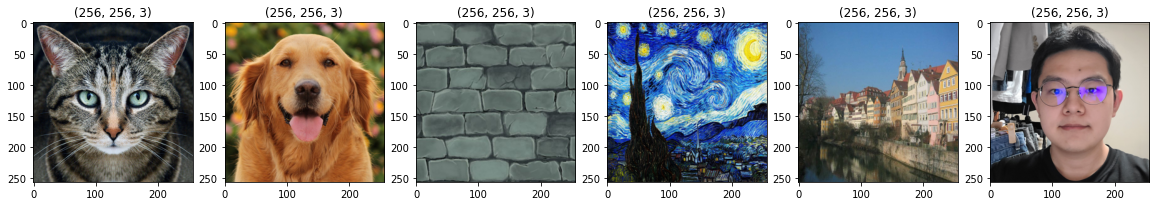

In [419]:
# Image를 띄워주는 영역
fig = plt.figure(figsize=(20, 8))
for idx, image in enumerate(np_images):
  plt.subplot(1, 6, idx + 1)
  plt.title(image.shape)
  plt.imshow(image)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


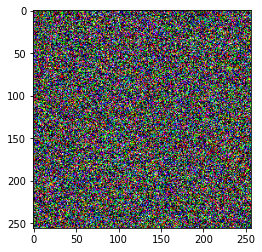

In [420]:
# Content Image 설정
content_image = np_images[5]
content_image = content_image[tf.newaxis, ...]
batch, width, height, channel = content_image.shape

# Style Image 설정
style_image = np_images[3]
style_image = style_image[tf.newaxis, ...]

# Content Image와 동일한 크기의 Noise 생성
noise = make_noises(batch, width, height, channel)
plt.imshow(noise[0, :, :, :])

In [421]:
# VGG19에서 content, style model로 활용할 Layer 설정
content_layers = ['block5_conv2']
style_layers   = ['block1_conv1',
                  'block2_conv1',
                  'block3_conv1',
                  'block4_conv1',
                  'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [422]:
# VGG에서 Layer을 추출해 새로운 모델 생성
def vgg_layers(layer_name):
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  outputs = [vgg.get_layer(name).output for name in layer_name]
  model = tf.keras.Model([vgg.input], outputs)

  return model

# Gram Matrix 만들기
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)

  return result/num_locations

In [423]:
# Style, Content 모델 선언
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def summary(self):
    self.vgg.summary()

  def call(self, inputs):
    inputs = inputs*255
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)

    # Style과 Content Layer로 추출된 Feature Result 분리
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])
    
    # Style Layer에서 추출된 Feature Results를 통해 Gram Matrix 연산 진행
    style_outputs = [gram_matrix(style_output)
                      for style_output in style_outputs]

    content_dict = {content_name:value
                      for content_name, value in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                      for style_name, value in zip(self.style_layers, style_outputs)}

    return {'content':content_dict, 'style':style_dict}

In [424]:
extractor = StyleContentModel(style_layers, content_layers)
extractor.summary()
results = extractor(tf.constant(content_image))

Model: "model_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0  

In [425]:
# Layer별 Style과 Contents Shape, Min, Max, Mean값 출력
print('스타일:')
for name, output in sorted(results['style'].items()):
  print(" ", name)
  print(" 크기: ", output.numpy().shape)
  print(" 최솟값: ", output.numpy().min())
  print(" 최댓값: ", output.numpy().max())
  print(" 평균: ", output.numpy().mean())
  print()

print("콘텐츠:")
for name, output in sorted(results['content'].items()):
  print(" ", name)
  print(" 크기: ", output.numpy().shape)
  print(" 최솟값: ", output.numpy().min())
  print(" 최댓값: ", output.numpy().max())
  print(" 평균: ", output.numpy().mean())

스타일:
  block1_conv1
 크기:  (1, 64, 64)
 최솟값:  0.0
 최댓값:  24232.906
 평균:  449.86682

  block2_conv1
 크기:  (1, 128, 128)
 최솟값:  0.0
 최댓값:  98034.23
 평균:  15968.889

  block3_conv1
 크기:  (1, 256, 256)
 최솟값:  0.0
 최댓값:  374839.88
 평균:  18919.176

  block4_conv1
 크기:  (1, 512, 512)
 최솟값:  0.0
 최댓값:  3903115.0
 평균:  278166.25

  block5_conv1
 크기:  (1, 512, 512)
 최솟값:  0.0
 최댓값:  361965.38
 평균:  3136.1602

콘텐츠:
  block5_conv2
 크기:  (1, 16, 16, 512)
 최솟값:  0.0
 최댓값:  1428.7483
 평균:  23.972307


In [426]:
def clip_0_1(image):
  # Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  # 위에 적힌 Warning을 해결하기 위함
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def style_content_loss(outputs):
  style_outputs = outputs['style']
  content_outputs = outputs['content']
  
  # Style Loss 연산
  style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                          for name in style_outputs.keys()])
  style_loss *= style_weight / num_style_layers

  # Content Loss 연산
  content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                          for name in content_outputs.keys()])
  content_loss *= content_weight / num_content_layers

  # Total Loss 연산
  loss = style_loss + content_loss

  return loss

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [427]:
# 하이퍼 파라미터
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']
image = tf.Variable(content_image)

opt = tf.optimizers.Adam(learning_rate=5e-3, beta_1=0.99, epsilon=1e-1)

style_weight=1e-4
content_weight=1e-4

start = time.time()
epochs = 100
steps_per_epoch = 100

training Image:   0%|          | 0/100 [00:00<?, ?it/s]

Image is saved
Image is saved
Image is saved
Image is saved
Image is saved
Image is saved
Image is saved
Image is saved
Image is saved
Image is saved


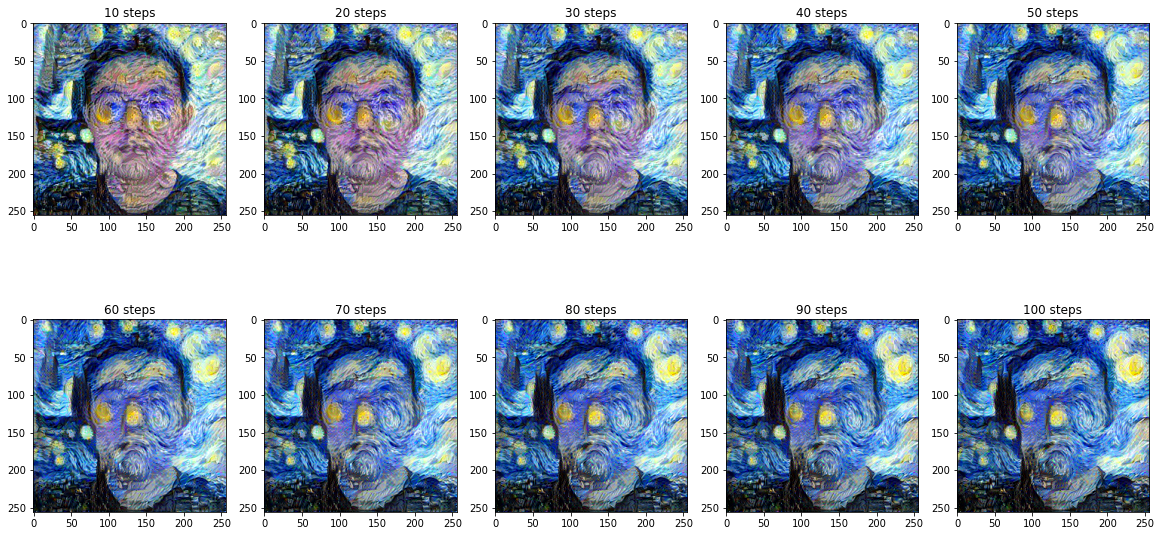

training step : 100
training time : 141.1


In [428]:
# 학습 진행
losses = []
fig = plt.figure(figsize=(20, 10))

for epoch in tqdm(range(epochs), desc="training Image"):
  for step in range(steps_per_epoch):
    train_step(image)

  if (epoch + 1) % 10 == 0:
    # Image 저장
    np_image = np.array(image[0, :, :, :]*255).astype(np.uint8)
    pil_image = PIL.Image.fromarray(np_image)
    pil_image.save('drive/MyDrive/dataset/StyleTransfer_Result/result_{}.png'.format(epoch + 1))
    print("Image is saved")

    # Image 시각화
    plt.subplot(2, 5, (epoch + 1)/10)
    plt.title('{} steps'.format(epoch + 1))
    plt.imshow(image[0, :, :, :])

plt.savefig('drive/MyDrive/dataset/StyleTransfer_Result/result_plt.pdf')
plt.show()

print(f'training step : {step+1}')
print(f'training time : {time.time() - start:.1f}')